In [1]:
import pandas as pd
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
from statsmodels.api import OLS
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import chain
import seaborn 
import pickle
import sklearn.metrics as sk
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor

## Pattern Statistics (all and experiment only) ##

In [2]:
## Get Experiment Pattern Indices ##
# Reasoning later in document #
test_patterns_indices = np.array([894, 423, 1367, 249, 939, 427, 590, 143, 912, 580, 1043, 673, 1359, 736, 678, 1355], dtype=float)
control_patterns = [678, 1355]
n_subjects = 43

In [3]:
## Extract Pattern Data ##
patterns_file = open(os.getcwd()+"/data/patterns.pkl", 'rb')
_patterns = pickle.load(patterns_file)
patterns_file.close()
n_patterns = len(_patterns)
print(n_patterns)

1378


In [4]:
## Partition Data ##
patterns = np.array([[[0, 0, 0] for x in range(16)] for y in range(n_patterns)], dtype=float) # (1378, 16, 3)

# Puts low/mid/high notes per step into workable array
for patt in range(n_patterns): # 1378
    for step in range(16): # 16
        for note in range(len(_patterns[patt][step])): # num notes on that step
            if _patterns[patt][step][note] == 1: # low channel note
                patterns[patt][step][0] += 1
            if _patterns[patt][step][note] == 2: # mid channel note
                patterns[patt][step][1] += 1
            if _patterns[patt][step][note] == 3: # high channel note
                patterns[patt][step][2] += 1

print("Example:")
for i in range(16):
    print(f"{i+1}: {_patterns[340][i]} --> {patterns[340][i]}")

Example:
1: [1, 3] --> [1. 0. 1.]
2: [2, 3] --> [0. 1. 1.]
3: [3, 2] --> [0. 1. 1.]
4: [2, 2] --> [0. 2. 0.]
5: [1, 2, 2, 3] --> [1. 2. 1.]
6: [] --> [0. 0. 0.]
7: [2, 3, 3] --> [0. 1. 2.]
8: [3] --> [0. 0. 1.]
9: [1, 2] --> [1. 1. 0.]
10: [3] --> [0. 0. 1.]
11: [2, 3, 2] --> [0. 2. 1.]
12: [2, 3] --> [0. 1. 1.]
13: [1, 2, 3] --> [1. 1. 1.]
14: [2, 3, 3] --> [0. 1. 2.]
15: [] --> [0. 0. 0.]
16: [2, 2] --> [0. 2. 0.]


In [61]:
## Characteristics of dataset patterns and selected patterns ##
note_counts = np.array([0.0 for x in range(5)], dtype=float) # [low,mid,high,rests,total]
exp_note_counts = note_counts.copy()

note_counts_by_step = np.array([[0.0 for x in range(4)] for y in range(16)], dtype=float) # [low,mid,high,total]
exp_note_counts_by_step = note_counts_by_step.copy()

for patt in range(n_patterns):
    for step in range(16):
        isrest=1
        for channel in range(3):
            value = patterns[patt][step][channel]
            
            if value > 0.1: # condition checking for all three channels not having a note
                isrest=0

            note_counts[channel] += value
            note_counts_by_step[step][channel] += value # per channel
            note_counts_by_step[step][3] += value # sum notes

            if np.isin(patt, test_patterns_indices): # if used in exp
                exp_note_counts[channel] += value
                exp_note_counts_by_step[step][channel] += value # per channel
                exp_note_counts_by_step[step][3] += value # sum notes

        if isrest==1: # remainder of rest check
            note_counts[3] += 1
            if np.isin(patt, test_patterns_indices):
                exp_note_counts[3] += 1
            

note_counts[4] = np.sum(note_counts[0:3])
exp_note_counts[4] = np.sum(exp_note_counts[0:3])
_note_counts_by_step = note_counts_by_step.T
_exp_note_counts_by_step = exp_note_counts_by_step.T
print(f"note cnts {note_counts}")
print(f"exp note cnts {exp_note_counts}")

note cnts [ 6238. 10708. 19208.  3799. 36154.]
exp note cnts [ 74. 113. 209.  48. 396.]


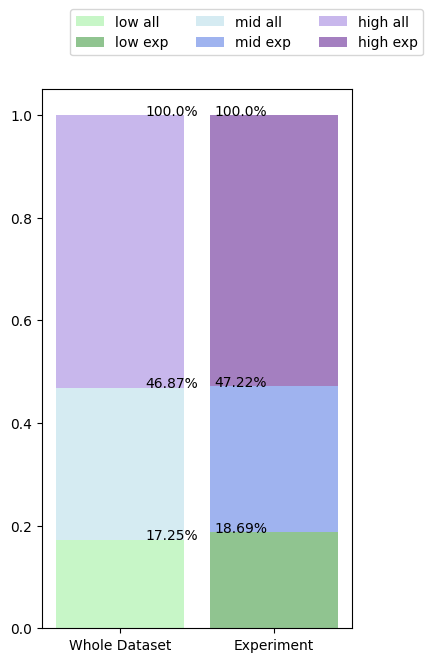

In [59]:
## Plotting percentages ##
colors_light=['lightgreen','lightblue','mediumpurple']
colors_dark=['forestgreen', 'royalblue','indigo']

fig, (ax) = plt.subplots(figsize=(4,7))
bottom =[0,0]
boxes =["low all","mid all", "high all","low exp", "mid exp", "high exp"]
for i in range(3):
    ax.bar(0.2,note_counts[i]/note_counts[4], color=colors_light[i], alpha=0.5,width=0.5, bottom=bottom[0], label=boxes[i])
    bottom[0] += note_counts[i]/note_counts[4]
    txt = np.round(bottom[0]*100, 2)
    ax.text(0.3, bottom[0], str(txt)+"%")

    ax.bar(0.8,exp_note_counts[i]/exp_note_counts[4], color=colors_dark[i], alpha=0.5,width=0.5, bottom=bottom[1], label=boxes[i+3])
    bottom[1] += exp_note_counts[i]/exp_note_counts[4]
    txt2 = np.round(bottom[1]*100, 2)
    ax.text(0.57, bottom[1], str(txt2)+"%")

ax.legend(bbox_to_anchor=([0.07, 1.05]), ncols=3)
ax.set_xticks([0.2,0.8])
ax.set_xticklabels(["Whole Dataset", "Experiment"])
plt.show()

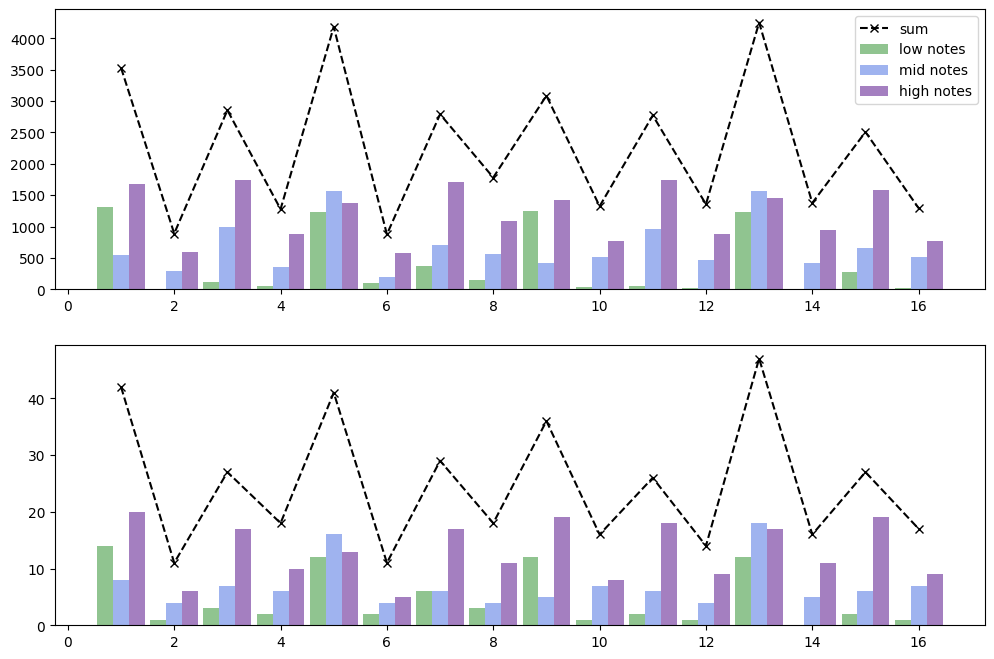

In [49]:
## Plot note distributions (OLD) ##
colors_light=['lightgreen','lightblue','mediumpurple']
colors_dark=['forestgreen', 'royalblue','indigo']

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
idx = np.arange(16)+1
idx_l = idx-0.3
idx_r = idx+0.3
pos=[-0.45,0.0,0.45]
bar_width = 0.3
ax1.bar(idx_l,_note_counts_by_step[0],color=colors_dark[0], alpha=0.5, width=bar_width, label="low notes")
ax2.bar(idx_l,_exp_note_counts_by_step[0], color=colors_dark[0], alpha=0.5, width=bar_width, label="low notes")

ax1.bar(idx,_note_counts_by_step[1],color=colors_dark[1], alpha=0.5, width=bar_width, label="mid notes")
ax2.bar(idx,_exp_note_counts_by_step[1], color=colors_dark[1], alpha=0.5, width=bar_width, label="mid notes")

ax1.bar(idx_r,_note_counts_by_step[2],color=colors_dark[2], alpha=0.5, width=bar_width, label="high notes")
ax2.bar(idx_r,_exp_note_counts_by_step[2], color=colors_dark[2], alpha=0.5, width=bar_width, label="high notes")

ax1.plot(idx, np.sum(_note_counts_by_step[:3], axis=0), color='black', linestyle="--", marker="x", label="sum")
ax2.plot(idx, np.sum(_exp_note_counts_by_step[:3], axis=0), color='black', linestyle="--", marker="x", label="sum")

ax1.legend()
plt.show()

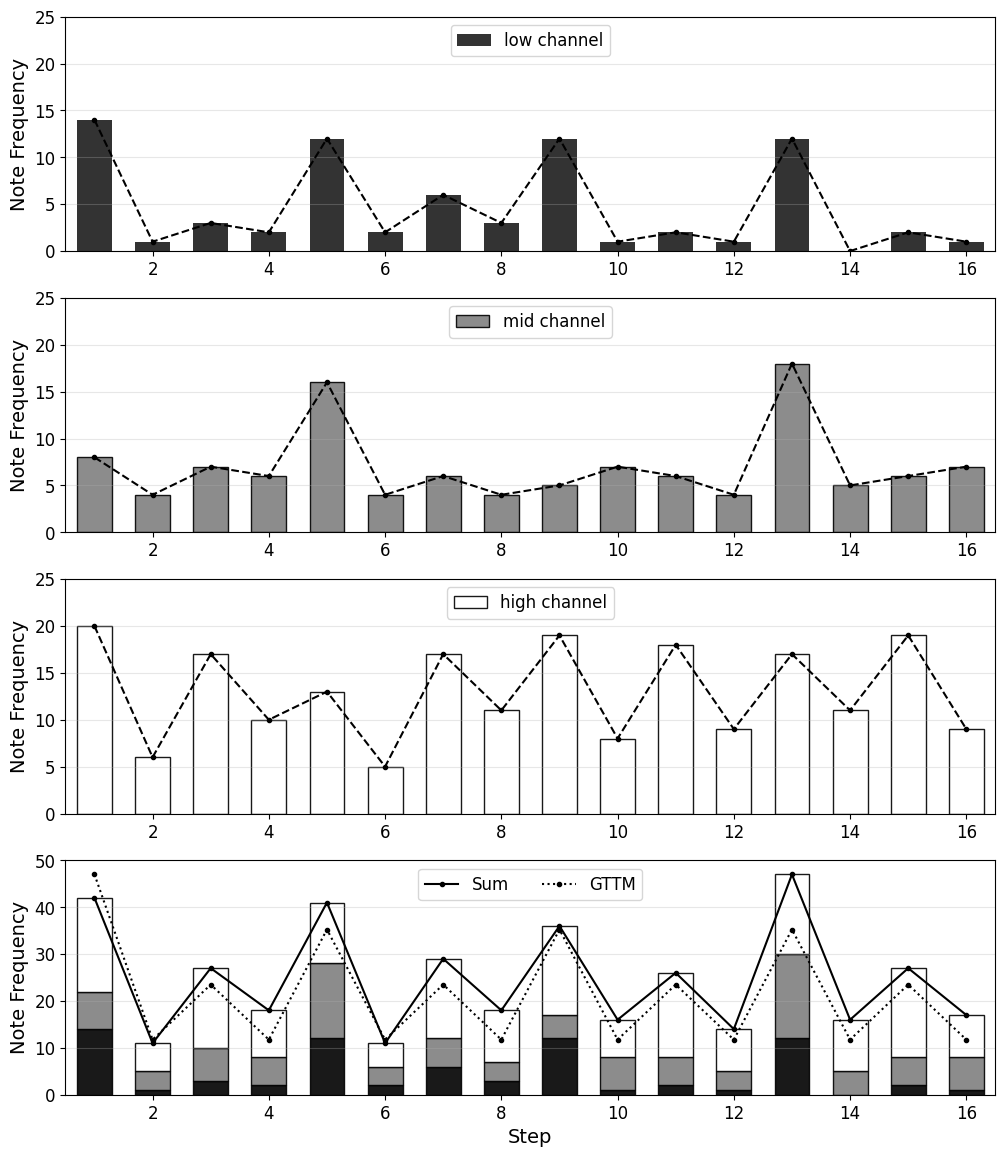

In [48]:
## Plot note distributions by step and channel ##
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,14))
#fig.subplots_adjust(hspace=0.3)

colors_light=['lightgreen','lightblue','mediumpurple']
colors_dark=['forestgreen', 'royalblue','indigo']

colors=["black","gray","white"]
idx = np.arange(16)+1
idx_l = idx-0.3
idx_r = idx+0.3
pos=[-0.45,0.0,0.45]
bar_width = 0.6
ax1.bar(idx,_exp_note_counts_by_step[0], color=colors[0], alpha=0.8, width=bar_width, label="low channel")

ax2.bar(idx,_exp_note_counts_by_step[1], color=colors[1], alpha=0.9, width=bar_width, label="mid channel", edgecolor='black')

ax3.bar(idx,_exp_note_counts_by_step[2], color=colors[2], alpha=0.9, width=bar_width, label="high channel", edgecolor='black')
bottom=np.array([0.0 for x in range(16)])
for i in range(3):
    ax4.bar(idx, _exp_note_counts_by_step[i], color=colors[i], alpha=0.9,width=bar_width, label="sum", bottom=bottom, edgecolor='black')
    bottom += _exp_note_counts_by_step[i]

ax1.plot(idx, _exp_note_counts_by_step[0], color='black', linestyle="--", marker=".")
ax2.plot(idx, _exp_note_counts_by_step[1], color='black', linestyle="--", marker=".")
ax3.plot(idx, _exp_note_counts_by_step[2], color='black', linestyle="--", marker=".")
line, =ax4.plot(idx, _exp_note_counts_by_step[3], color='black', linestyle="-", marker=".")

gttm = np.array([4,1,2,1,3,1,2,1,3,1,2,1,3,1,2,1],dtype=float)
gttm /= np.max(gttm)
gttm *= np.max(_exp_note_counts_by_step[3])
line2, =ax4.plot(idx, gttm, color='black', linestyle=":", marker=".")

plts = [ax1,ax2,ax3,ax4]
for p in plts:
    p.grid(alpha=0.3, axis='y')
    p.tick_params(labelsize=12)
    if p!=ax4:
        p.legend(loc='upper center', ncols=1, fontsize="large")
    p.set_xlim([0.5,16.5])
    p.set_ylim([0,25])
    p.set_ylabel("Note Frequency", fontsize=14)
ax4.set_xlabel("Step", fontsize=14)
ax4.set_ylim([0,50])

ax4.legend([line, line2], ("Sum", "GTTM"), loc="upper center", ncols=2, fontsize="large")
plt.show()


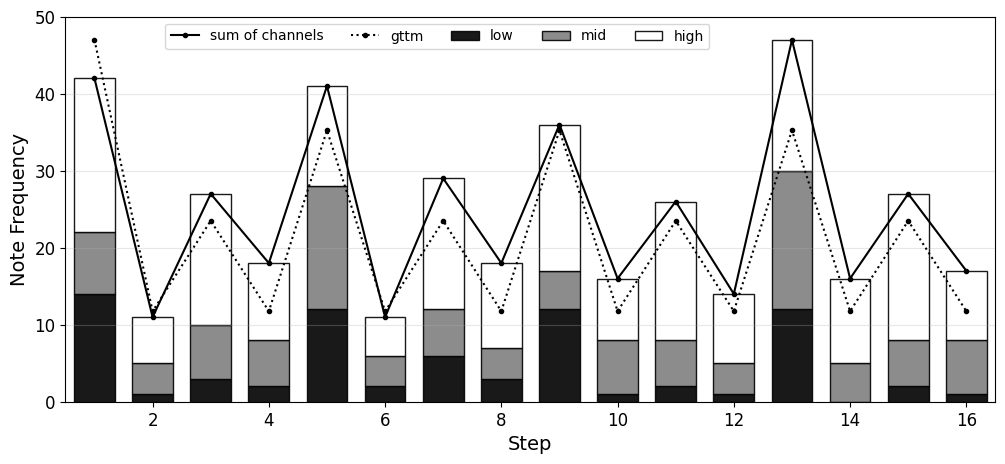

In [62]:
## Plot last graph from cell above ##
fig, (ax4) = plt.subplots(figsize=(12,5))
names=["low","mid","high"]
colors=["black","gray","white"]
mpl.rcParams['hatch.color'] = 'white'
bottom=np.array([0.0 for x in range(16)])
for i in range(3):
    ax4.bar(idx, _exp_note_counts_by_step[i], color=colors[i], alpha=0.9,width=.7, label=f"{names[i]}", bottom=bottom, edgecolor="black")
    bottom += _exp_note_counts_by_step[i]
line, =ax4.plot(idx, _exp_note_counts_by_step[3], color='black', linestyle="-", marker=".", label="sum of channels")

gttm = np.array([4,1,2,1,3,1,2,1,3,1,2,1,3,1,2,1],dtype=float)
gttm /= np.max(gttm)
gttm *= np.max(_exp_note_counts_by_step[3])
line2, =ax4.plot(idx, gttm, color='black', linestyle=":", marker=".", label='gttm')

plts = [ax4]
for p in plts:
    p.grid(alpha=0.3, axis='y')
    if p!=ax4:
        p.legend(loc='upper center', ncols=1)
    p.set_xlim([0.5,16.5])
    p.set_ylim([0,25])
    p.set_ylabel("Note Frequency", fontsize=14)
    ax4.set_ylim([0,50])
ax4.tick_params(labelsize=12)
ax4.set_xlabel("Step", fontsize=14)
ax4.legend(loc="upper center", ncols=5,bbox_to_anchor=[.4,1])
plt.show()

## Experiment Statistics ##

In [269]:
## Extract experiment data ##
data = []
tap_file = os.getcwd()+"/data/tapexplore.csv"
with open(tap_file) as results: 
    reader = csv.reader(results)
    for row in reader:
        data.append(row)
    results.close()


In [273]:
## Clean csv file (if necessary) ## 
_tap_data = []
for row in data:
    line = row[2:20]
    _tap_data.append(line)
for i in range(3):
    print(_tap_data[i])

['NAME', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15', 't16', 'c1']
['1355', 'breakbeat_unconventional_DMR_1', '0.716535433', '0', '0', '0', '0.661417323', '0', '0.700787402', '0', '0', '0', '0.716535433', '0', '0.732283465', '0', '0', '0']
['1043', 'chicago_promisedland_138', '0.496062992', '0', '0.417322835', '0', '0.488188976', '0', '0', '0', '0.42519685', '0', '0.456692913', '0', '0.480314961', '0', '0', '0']


In [417]:
tap_data = np.array([[[0.0 for x in range(17)] for y in range(18)] for z in range(n_subjects)], dtype=float)
tap_data_pattern = np.array([[[0.0 for x in range(16)] for y in range(n_subjects)] for z in range(18)], dtype=float)
tap_data_subjects = np.array([[[0.0 for x in range(16)] for y in range(18)] for z in range(n_subjects)], dtype=float)
tap_data_controls = np.array([[[0.0 for x in range(16)] for y in range(4)] for z in range(n_subjects)], dtype=float)
n=0
subj=0
ctrl=[0,0]

_tap_data_no_header = _tap_data[1:]
long_index = 0
for n in range(n_subjects): 
    for t in range(18):
        # tap data looks like this now: (subj, tap_in_exp_order, index+16steps)
        tap_data[n][t][0] = _tap_data_no_header[long_index][0]
        tap_data[n][t][1:] = _tap_data_no_header[long_index][2:]
        long_index+=1
        #if n==13:
        #    print(" ".join([f"{x:.2f}" for x in tap_data[n][t]]))

for n in range(n_subjects):
    # for each person
    tap_results = tap_data[n] #(18patts,17(idx+16steps))
    for p in range(len(tap_results)):
        # for all 18 patterns tapped
        pattern_num=int(tap_results[p][0])
        pattern_index = np.where(pattern_num==test_patterns_indices)[0][0]

        # control check (if second appearance, place at end)
        # for tap_data_controls
        if ctrl[0]>0 and pattern_num==678:
            tap_data_controls[n][1] = tap_results[p][1:]
            pattern_index = 16
        if ctrl[1]>0 and pattern_num==1355:
            tap_data_controls[n][3] = tap_results[p][1:]
            pattern_index = 17
        
        # control check for first appearance
        if pattern_num==678 and ctrl[0]==0:
            tap_data_controls[n][0] = tap_results[p][1:]
            ctrl[0]+=1
            
        if pattern_num==1355 and ctrl[1]==0:
            tap_data_controls[n][2] = tap_results[p][1:]
            ctrl[1]+=1

        # both are sorted by test_patterns order (very first cell)
        tap_data_pattern[pattern_index][n] = tap_results[p][1:]
        tap_data_subjects[n][pattern_index] = tap_results[p][1:]
    
    ctrl=[0,0] # reset for next subj

print((tap_data_controls[1,0]-tap_data_controls[1,1])) # subj 2, 678 1st minus 2nd

print(tap_data.shape)
print(tap_data_pattern.shape)
print(tap_data_subjects.shape)
print(tap_data_controls.shape)


[ 0.          0.          0.00787402  0.          0.05511811  0.
  0.01574803 -0.07086614  0.03149606  0.01574803  0.06299213 -0.33574238
  0.04724409  0.05511811  0.09448819 -0.31406072]
(43, 18, 17)
(18, 43, 16)
(43, 18, 16)
(43, 4, 16)


control_precision - (43, 2, 16)
precision_means - (43, 2)
678: m=0.170 sd=0.118
1355: m=0.118 sd=0.099
0.2884 0.2165
outliers: 10


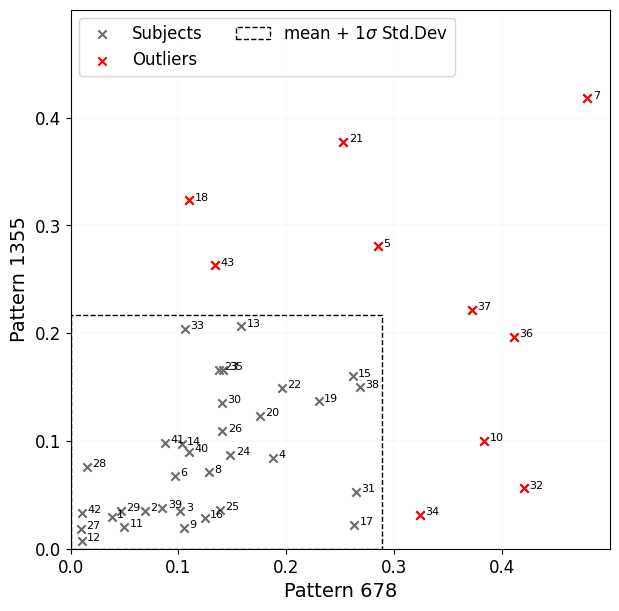

In [426]:
fig, (ax1) = plt.subplots(figsize=(7,7))
ax1.set_aspect('equal')

control_precision = np.array([[[0.0 for x in range(16)] for y in range(2)] for z in range(n_subjects)], dtype=float)
control_means = np.array([[0.0 for x in range(16)] for y in range(2)], dtype=float)


for n in range(n_subjects): # find differences in tapping to same pattern
    control_precision[n][0] = (tap_data_controls[n][0]-tap_data_controls[n][1]) # 678
    control_precision[n][1] = (tap_data_controls[n][2]-tap_data_controls[n][3]) # 1355

    control_means[0] += (tap_data_controls[n][0]+tap_data_controls[n][1])/2
    control_means[1] += (tap_data_controls[n][2]+tap_data_controls[n][3])/2
control_means[:] /= n_subjects

precision_means = np.mean(np.abs(control_precision), axis=2) #(43,2)
print(f"control_precision - {control_precision.shape}")
print(f"precision_means - {precision_means.shape}")
print(f"678: m={np.mean(np.abs(precision_means[:,0])):.3f} sd={np.std(precision_means[:,0]):.3f}")
print(f"1355: m={np.mean(np.abs(precision_means[:,1])):.3f} sd={np.std(precision_means[:,1]):.3f}")



# Get std devs of precision per pattern
sd_678=np.std(precision_means[:,0])+np.mean(np.abs(precision_means[:,0]))
sd_1355=np.std(precision_means[:,1])+np.mean(np.abs(precision_means[:,1]))
print(f"{sd_678:.4f} {sd_1355:.4f}")


## Precision by Control Pattern ##


# scatter here for legend organization
ax1.scatter(precision_means[:,0], precision_means[:,1], marker='x', color='dimgrey', label="Subjects")

red=[]
n_clean = 0
_tap_data_clean=[]
for i in range(n_subjects):
    ax1.text(precision_means[i][0]+0.005, precision_means[i][1], str(i+1), fontsize=8) # plot subj text
    if precision_means[i,0] > sd_678: # precision check 678
        red.append(precision_means[i])

    elif precision_means[i,1] > sd_1355: # precision check 1355
        red.append(precision_means[i])
    else:
        _tap_data_clean.append(tap_data_subjects[i][:16]) # else add to 
        n_clean+=1
tap_data_clean=np.array(_tap_data_clean,dtype=float)
red=np.array(red, dtype=float)
ax1.scatter(red[:,0], red[:,1], marker='x', color='red', label="Outliers") #plot outliers
p1=(sd_678,0)
p2=(0,sd_1355)
rect = mpl.patches.Rectangle((p2[0], p1[1]), p1[0] - p2[0], p2[1] - p1[1], linewidth=1, edgecolor='black', facecolor='none', linestyle='--', label=r'mean + 1$\sigma$ Std.Dev')
ax1.add_patch(rect)

""" p1=(sd_678,-sd_1355)
p2=(-sd_678,sd_1355)
rect = mpl.patches.Rectangle((p2[0], p1[1]), p1[0] - p2[0], p2[1] - p1[1], linewidth=1, edgecolor='black', facecolor='none', linestyle=':', label=r'1$\sigma$ Std.Dev')
ax1.add_patch(rect) """
print(f"outliers: {n_subjects-n_clean}")

ax1.set_xlabel("Pattern 678", fontsize=14, fontfamily='sans-serif')
ax1.set_ylabel("Pattern 1355", fontsize=14, fontfamily='sans-serif')
x=0.5
y=0.5
ax1.set(xlim=[0,x], ylim=[0,y], xticks=np.arange(0,x,0.1), yticks=np.arange(0,y,0.1))
ax1.tick_params(labelsize=12)
ax1.grid(color='lightgrey', linewidth=0.3, alpha=0.4)
ax1.legend(fontsize="large", ncols=2, loc='upper left')
plt.show()

(4103,)
4345


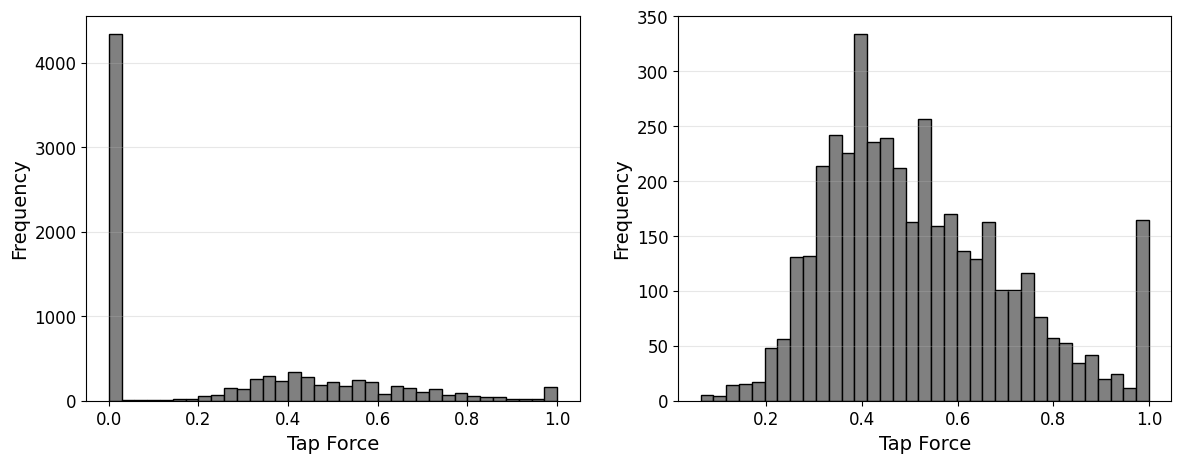

In [427]:
fig,(ax, ax1)=plt.subplots(1,2, figsize=(14,5))
hist = tap_data_clean[tap_data_clean>0.05]
print(hist.shape)
ax1.hist(hist.ravel(), bins=35, color="gray", edgecolor='black')
ax.grid(alpha=0.3, axis='y')
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel("Tap Force", fontsize=14)
ax.tick_params(labelsize=12)
print(f"{len(tap_data_clean.ravel())-len(tap_data_clean[tap_data_clean>0.05])}")
ax.hist(tap_data_clean.ravel(), bins=35, color="gray", edgecolor='black')
ax1.grid(alpha=0.3, axis='y')
ax1.set_ylabel("Frequency", fontsize=14)
ax1.set_xlabel("Tap Force", fontsize=14)
ax1.tick_params(labelsize=12)
plt.show()

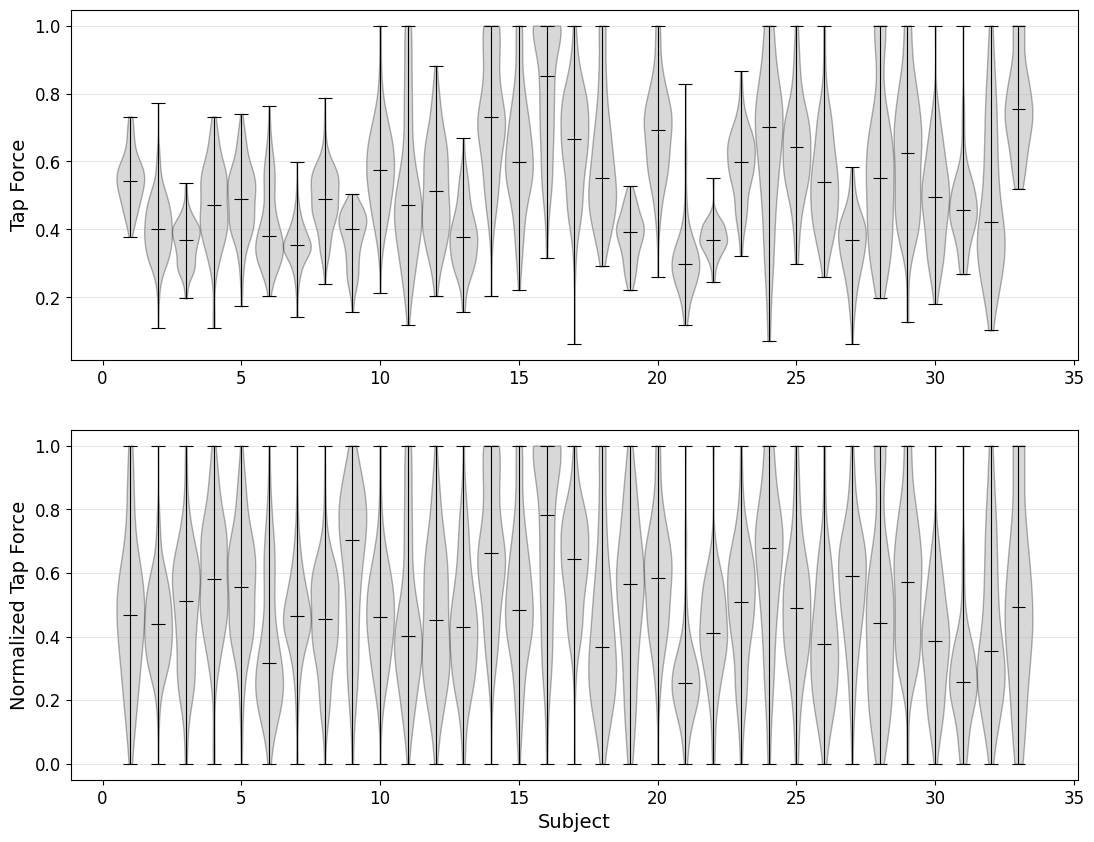

In [439]:
fig,(ax, ax1)=plt.subplots(2,1, figsize=(13,10))
index = np.arange(len(tap_data_clean))+1
graph=np.array([[0.0 for x in range(256)] for y in range(len(tap_data_clean))], dtype=float)
for i in range(len(tap_data_clean)):
    graph[i] = tap_data_clean[i].ravel()
top=[]
bottom=[]
for subj,data in enumerate(graph):
    _graph=data[data>0.05]
    _graph_norm=((_graph-np.min(_graph)) / (np.max(_graph)-np.min(_graph)))
    violin = ax.violinplot([_graph],positions=[subj+1], showmedians=True, widths=1.0, vert=True)
    #plt.setp(plt.gca().get_xticklabels(), visible=False)
    violin2 = ax1.violinplot([_graph_norm],positions=[subj+1], showmedians=True, widths=1.0, vert=True)
    #plt.setp(plt.gca().get_xticklabels(), visible=False)
    for v in violin['bodies']:
        v.set_facecolor('grey')
        v.set_edgecolor('black')
    for v in violin2['bodies']:
        v.set_facecolor('grey')
        v.set_edgecolor('black')    
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = violin[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(0.8)
        vp.set_alpha(1)
        vp = violin2[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(0.8)
        vp.set_alpha(1)

    top.append(_graph)
    bottom.append(_graph_norm)
top = list(chain(*top))
top=np.array(top, dtype=float)
bottom = list(chain(*bottom))
bottom=np.array(bottom, dtype=float)

ax.grid(alpha=0.3, axis='y')
ax.set_ylabel("Tap Force", fontsize=14)
ax.tick_params(labelsize=12)

ax1.grid(alpha=0.3, axis='y')
ax1.set_ylabel("Normalized Tap Force", fontsize=14)
ax1.set_xlabel("Subject", fontsize=14)
ax1.tick_params(labelsize=12)
plt.show()